# 🫀 Kaggle Playground Series 2026 - Heart Disease Prediction

**Goal**: Predict the probability of Heart Disease (Target ROC-AUC: 95+)

---

## Table of Contents
1. [Setup & Imports](#1-setup--imports)
2. [Data Loading & Exploration](#2-data-loading--exploration)
3. [Feature Engineering](#3-feature-engineering)
4. [Preprocessing](#4-preprocessing)
5. [Model Training](#5-model-training)
6. [Ensemble & Stacking](#6-ensemble--stacking)
7. [Hyperparameter Optimization](#7-hyperparameter-optimization)
8. [Submission](#8-submission)

---
## 1. Setup & Imports

In [37]:
# Core Libraries
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

# ML Tools
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# Models
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Optimization
import optuna
from scipy.optimize import minimize

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


---
## 2. Data Loading & Exploration

### 2.1 Load the Data

In [38]:
# Configuration - Update paths as needed
# For Kaggle environment:
# DATA_DIR = '/kaggle/input/playground-series-s6e2'

# For local environment:
DATA_DIR = r'/kaggle/input/playground-series-s6e2'

train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

Train shape: (630000, 15)
Test shape: (270000, 14)
Sample submission shape: (270000, 2)


### 2.2 First Look at the Data

In [39]:
# Display first few rows
train.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [40]:
# Data types and info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              630000 non-null  int64  
 6   FBS over 120             630000 non-null  int64  
 7   EKG results              630000 non-null  int64  
 8   Max HR                   630000 non-null  int64  
 9   Exercise angina          630000 non-null  int64  
 10  ST depression            630000 non-null  float64
 11  Slope of ST              630000 non-null  int64  
 12  Number of vessels fluro  630000 non-null  int64  
 13  Thallium                 630000 non-null  int64  
 14  Hear

In [41]:
# Column names for reference
print("Train columns:", train.columns.tolist())
print("\nTest columns:", test.columns.tolist())

Train columns: ['id', 'Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease']

Test columns: ['id', 'Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium']


### 2.3 Target Distribution

Target Column: 'Heart Disease'

Target Distribution:
Heart Disease
Absence     0.55166
Presence    0.44834
Name: proportion, dtype: float64


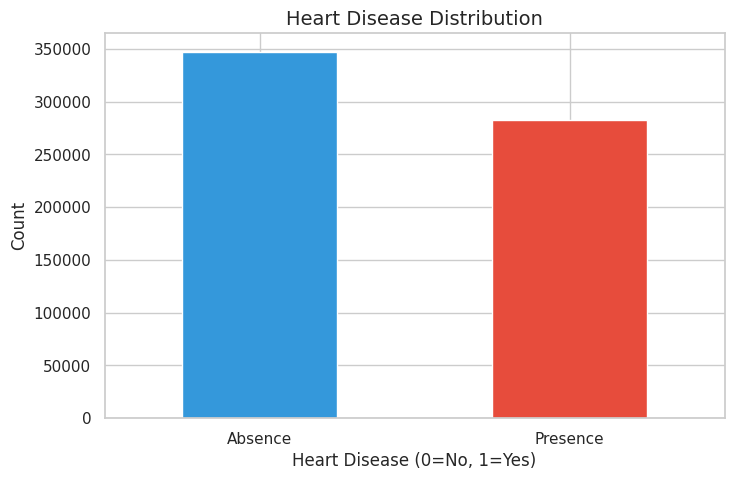

In [42]:
# Find the target column (handle different naming)
TARGET = 'Heart Disease'
ID_COL = 'id'

# Check if target exists
if TARGET in train.columns:
    print(f"Target Column: '{TARGET}'")
    print("\nTarget Distribution:")
    print(train[TARGET].value_counts(normalize=True))
    
    # Visualize
    plt.figure(figsize=(8, 5))
    train[TARGET].value_counts().plot(kind='bar', color=['#3498db', '#e74c3c'])
    plt.title('Heart Disease Distribution', fontsize=14)
    plt.xlabel('Heart Disease (0=No, 1=Yes)')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()
else:
    print("⚠️ Target column not found. Available columns:", train.columns.tolist())

### 2.4 Missing Values Analysis

In [43]:
# Check missing values
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()

print("=== Missing Values in Train ===")
print(missing_train[missing_train > 0] if missing_train.sum() > 0 else "No missing values!")

print("\n=== Missing Values in Test ===")
print(missing_test[missing_test > 0] if missing_test.sum() > 0 else "No missing values!")

=== Missing Values in Train ===
No missing values!

=== Missing Values in Test ===
No missing values!


### 2.5 Numerical Feature Distributions

In [44]:
# Statistical summary
train.describe()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,54.136706,0.714735,3.312752,130.497433,245.011814,0.079987,0.981660,152.816763,0.273725,0.716028,1.455871,0.451040,4.618873
std,181865.479132,8.256301,0.451541,0.851615,14.975802,33.681581,0.271274,0.998783,19.112927,0.445870,0.948472,0.545192,0.798549,1.950007
min,0.000000,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,157499.750000,48.000000,0.000000,3.000000,120.000000,223.000000,0.000000,0.000000,142.000000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,314999.500000,54.000000,1.000000,4.000000,130.000000,243.000000,0.000000,0.000000,157.000000,0.000000,0.100000,1.000000,0.000000,3.000000
75%,472499.250000,60.000000,1.000000,4.000000,140.000000,269.000000,0.000000,2.000000,166.000000,1.000000,1.400000,2.000000,1.000000,7.000000
max,629999.000000,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


In [45]:
# Identify numerical and categorical columns
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = [c for c in num_cols if c not in [ID_COL, TARGET]]  # Exclude id and target

cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical columns ({len(num_cols)}): {num_cols}")
print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")

Numerical columns (13): ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium']
Categorical columns (1): ['Heart Disease']


In [46]:
# 1. Map the Target labels to numbers
target_mapping = {'Presence': 1, 'Absence': 0}

# Replace 'Heart Disease' with the exact name of your target column
if 'Heart Disease' in train.columns:
    train['Heart Disease'] = train['Heart Disease'].map(target_mapping)

# 2. Make sure num_cols ONLY includes actual numbers
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 3. Now run your correlation code
if len(num_cols) > 0:
    corr_matrix = train[num_cols].corr()
    # ... (rest of your plotting code)

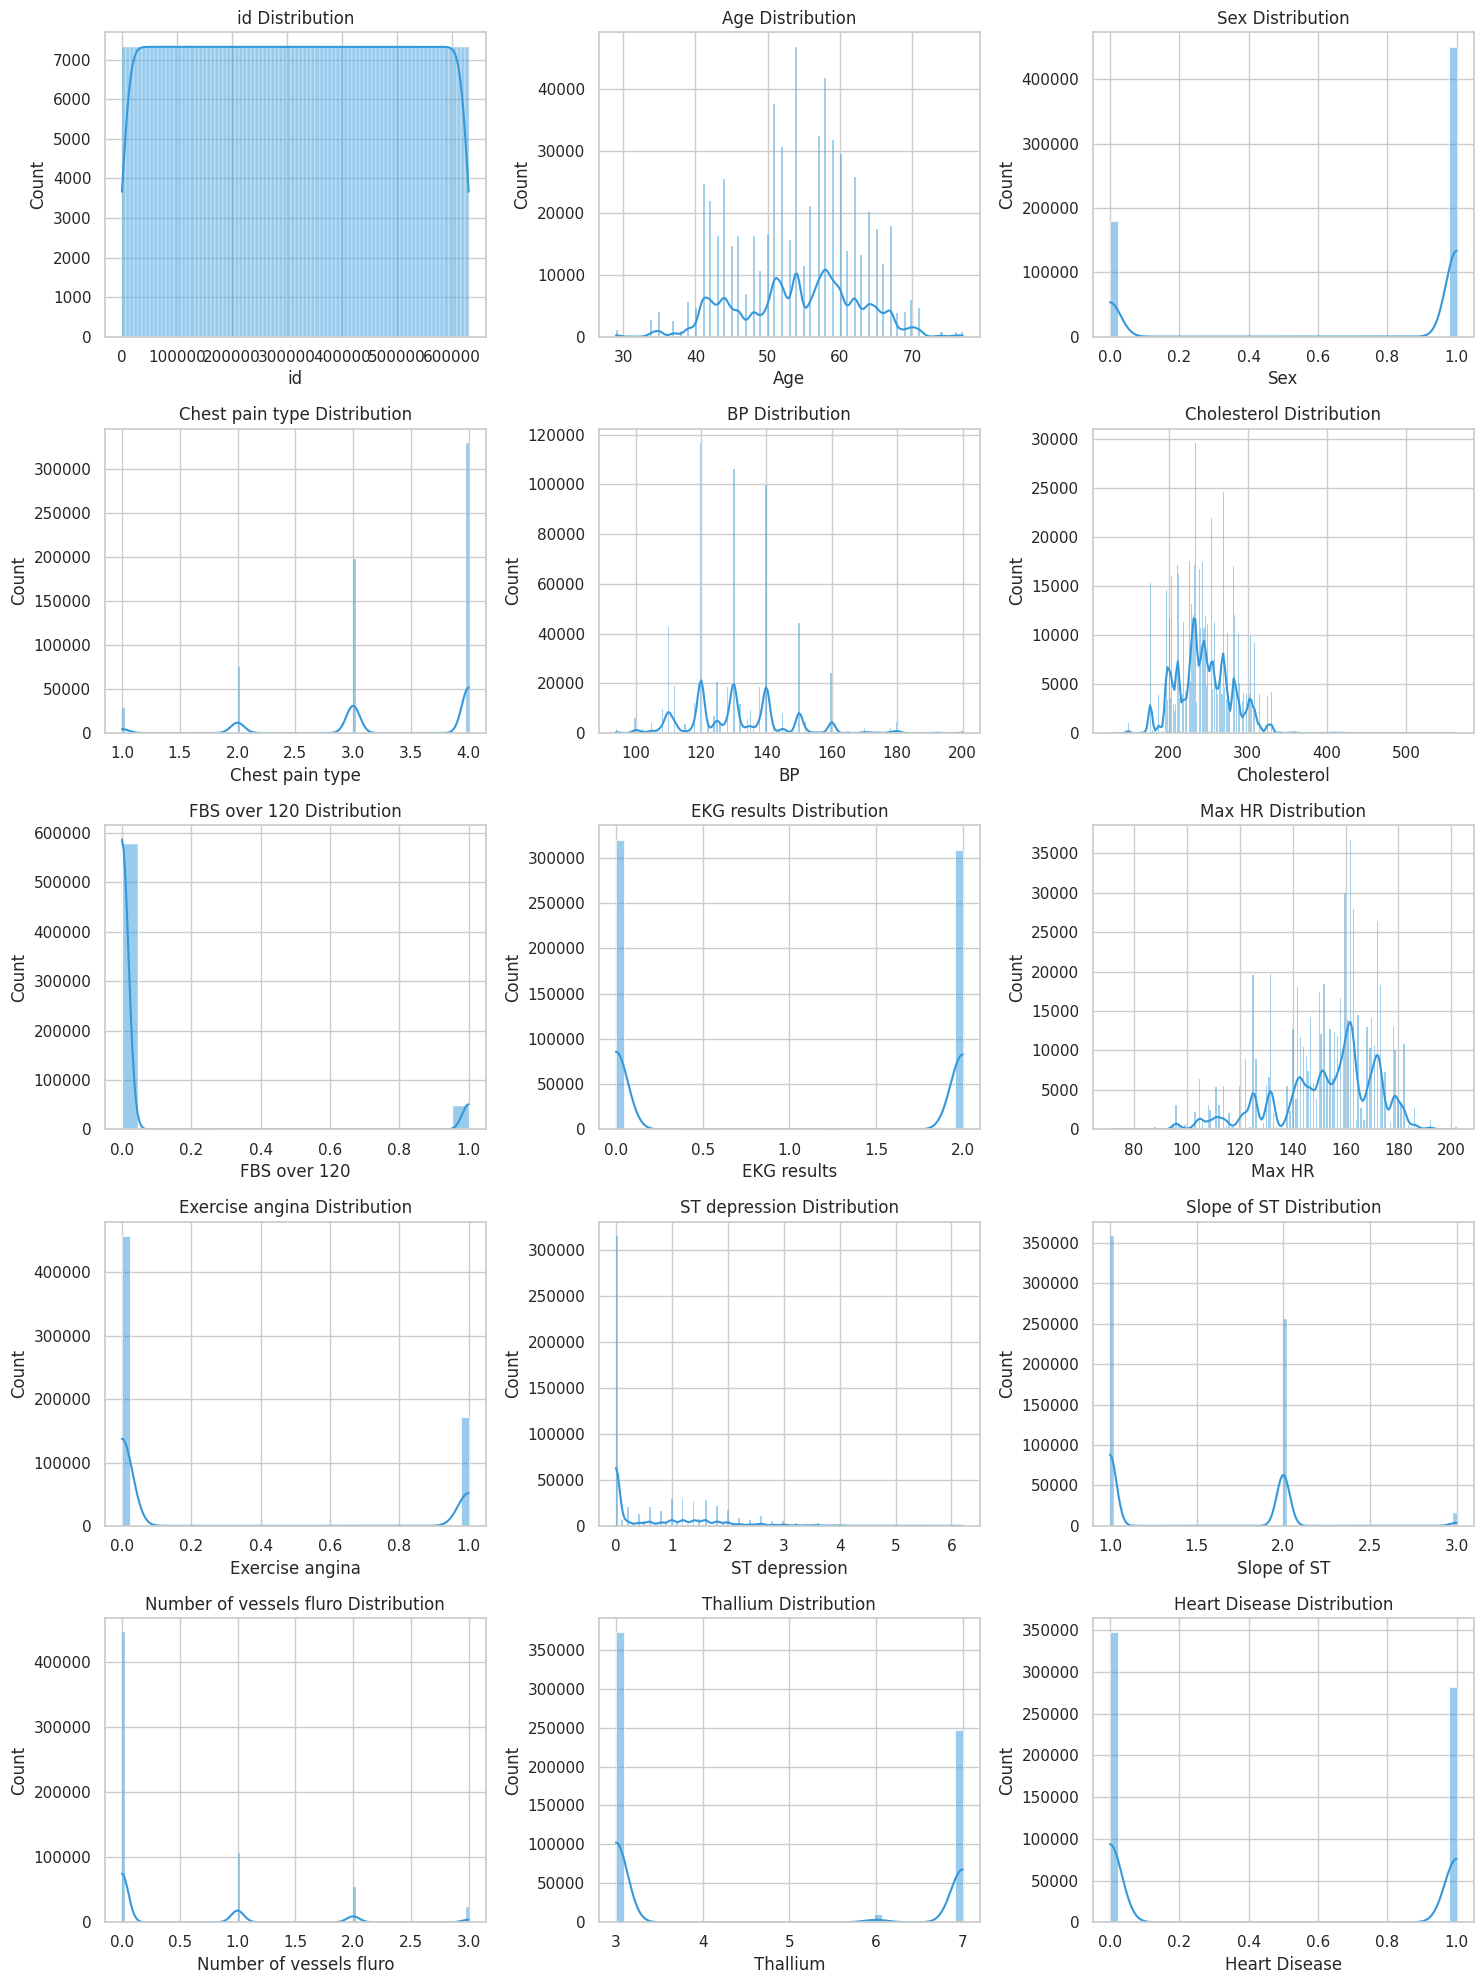

In [47]:
# Plot distributions of numerical features
if len(num_cols) > 0:
    n_cols = 3
    n_rows = (len(num_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(num_cols):
        sns.histplot(train[col], kde=True, ax=axes[i], color='#3498db')
        axes[i].set_title(f'{col} Distribution')
    
    # Hide empty subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

### 2.6 Train vs Test Distribution Check (Adversarial Validation Prep)

In [49]:
# 1. Define your target name clearly
TARGET = 'Heart Disease'

# 2. Get numerical columns, but EXCLUDE the target column
# This ensures we only compare features that exist in both train and test
num_cols = [c for c in train.select_dtypes(include=['int64', 'float64']).columns 
            if c != TARGET and c != 'id']

# 3. Now run your comparison (this will no longer crash)
if len(num_cols) > 0:
    comparison = pd.DataFrame({
        'Train Mean': train[num_cols].mean(),
        'Test Mean': test[num_cols].mean(),
        'Train Std': train[num_cols].std(),
        'Test Std': test[num_cols].std(),
    }, index=num_cols)

    comparison['Mean Diff %'] = ((comparison['Test Mean'] - comparison['Train Mean']) / comparison['Train Mean'] * 100).round(2)

    print("=== Train vs Test Distribution Comparison (Features Only) ===")
    print(comparison)
else:
    print("No numerical columns found to compare.")

=== Train vs Test Distribution Comparison (Features Only) ===
                         Train Mean   Test Mean  Train Std   Test Std  \
Age                       54.136706   54.159870   8.256301   8.255471   
Sex                        0.714735    0.716315   0.451541   0.450787   
Chest pain type            3.312752    3.315107   0.851615   0.851762   
BP                       130.497433  130.555089  14.975802  15.007908   
Cholesterol              245.011814  245.045270  33.681581  33.695458   
FBS over 120               0.079987    0.080052   0.271274   0.271374   
EKG results                0.981660    0.978493   0.998783   0.998686   
Max HR                   152.816763  152.783756  19.112927  19.153454   
Exercise angina            0.273725    0.274656   0.445870   0.446341   
ST depression              0.716028    0.718082   0.948472   0.947417   
Slope of ST                1.455871    1.459356   0.545192   0.546186   
Number of vessels fluro    0.451040    0.454800   0.798549   0

### 2.7 Correlation Matrix

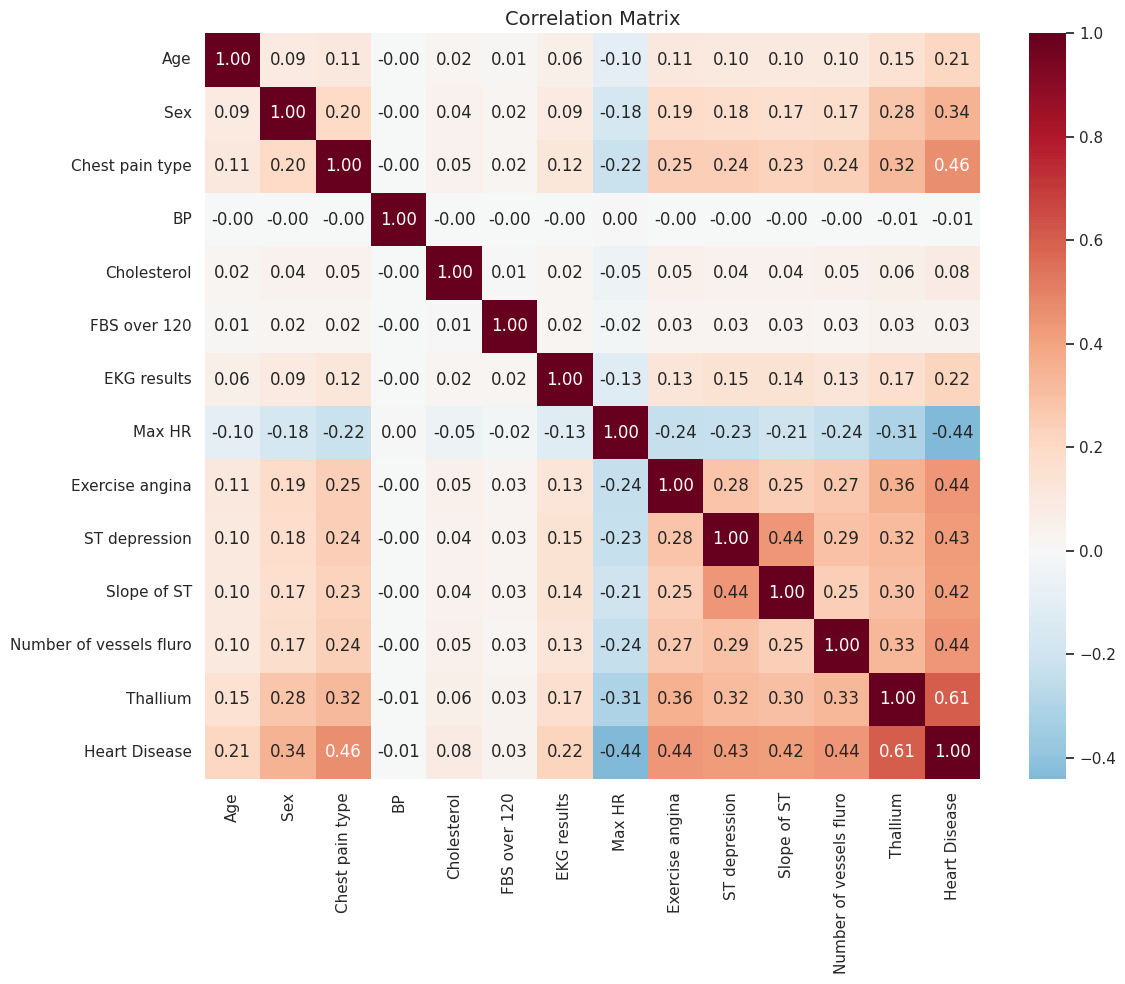

In [50]:
# Correlation heatmap for numerical features
if len(num_cols) > 0:
    corr_cols = num_cols + [TARGET] if TARGET in train.columns else num_cols
    corr_matrix = train[corr_cols].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
    plt.title('Correlation Matrix', fontsize=14)
    plt.tight_layout()
    plt.show()

---
## 3. Feature Engineering

Creating domain-driven features based on medical knowledge about heart disease risk factors.

In [52]:
def perform_feature_engineering(df):
    """
    Advanced Feature Engineering for Heart Disease Prediction
    """
    df = df.copy()
    cols = df.columns.tolist()
    
    # ===== 1. Health Ratios =====
    # Cholesterol risk increases with age
    if 'Cholesterol' in cols and 'Age' in cols:
        df['chol_age_ratio'] = df['Cholesterol'] / (df['Age'] + 1)
        print("✅ Created: chol_age_ratio")
    
    # Blood pressure to age ratio
    if 'Systolic BP' in cols and 'Age' in cols:
        df['bp_age_ratio'] = df['Systolic BP'] / (df['Age'] + 1)
        print("✅ Created: bp_age_ratio")
    
    # ===== 2. Blood Pressure Dynamics =====
    if 'Systolic BP' in cols and 'Diastolic BP' in cols:
        # Pulse Pressure - key heart disease indicator
        df['pulse_pressure'] = df['Systolic BP'] - df['Diastolic BP']
        print("✅ Created: pulse_pressure")
        
        # Mean Arterial Pressure
        df['mean_arterial_pressure'] = (df['Systolic BP'] + 2 * df['Diastolic BP']) / 3
        print("✅ Created: mean_arterial_pressure")
        
        # Hypertension flag
        df['is_hypertensive'] = ((df['Systolic BP'] > 140) | (df['Diastolic BP'] > 90)).astype(int)
        print("✅ Created: is_hypertensive")
    
    # ===== 3. Age Binning (Medical Risk Categories) =====
    if 'Age' in cols:
        df['age_group'] = pd.cut(df['Age'], 
                                  bins=[0, 30, 45, 60, 75, 100], 
                                  labels=['Young', 'Middle', 'Senior', 'Elder', 'Advanced'])
        print("✅ Created: age_group")
    
    # ===== 4. Interaction Features =====
    if 'Age' in cols and 'Cholesterol' in cols:
        df['age_chol_interaction'] = df['Age'] * df['Cholesterol']
        print("✅ Created: age_chol_interaction")
    
    # ===== 5. Missing Value Indicators =====
    for col in cols:
        if df[col].isnull().any():
            df[f'{col}_is_missing'] = df[col].isnull().astype(int)
            print(f"✅ Created: {col}_is_missing")
    
    return df

print("Feature Engineering function defined!")

Feature Engineering function defined!


In [53]:
# Apply Feature Engineering
print("=== Applying Feature Engineering to Train ===")
train_fe = perform_feature_engineering(train)

print("\n=== Applying Feature Engineering to Test ===")
test_fe = perform_feature_engineering(test)

print(f"\nTrain shape after FE: {train_fe.shape}")
print(f"Test shape after FE: {test_fe.shape}")

=== Applying Feature Engineering to Train ===
✅ Created: chol_age_ratio
✅ Created: age_group
✅ Created: age_chol_interaction

=== Applying Feature Engineering to Test ===
✅ Created: chol_age_ratio
✅ Created: age_group
✅ Created: age_chol_interaction

Train shape after FE: (630000, 18)
Test shape after FE: (270000, 17)


---
## 4. Preprocessing

In [54]:
def preprocess_data(train_df, test_df, target_col, id_col):
    """
    Robust preprocessing with dynamic column detection.
    """
    # Separate features and target
    y = train_df[target_col]
    X = train_df.drop([target_col, id_col], axis=1, errors='ignore')
    X_test = test_df.drop([id_col], axis=1, errors='ignore')
    
    # Align columns
    common_cols = X.columns.intersection(X_test.columns)
    X = X[common_cols]
    X_test = X_test[common_cols]
    
    print(f"Features after alignment: {len(common_cols)}")
    
    # Identify column types
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()
    
    print(f"Numerical: {len(num_cols)}, Categorical: {len(cat_cols)}")
    
    # Imputation
    if num_cols:
        num_imputer = SimpleImputer(strategy='median')
        X[num_cols] = num_imputer.fit_transform(X[num_cols])
        X_test[num_cols] = num_imputer.transform(X_test[num_cols])
    
    if cat_cols:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])
        X_test[cat_cols] = cat_imputer.transform(X_test[cat_cols])
        
        # Label Encoding
        for col in cat_cols:
            le = LabelEncoder()
            combined = pd.concat([X[col], X_test[col]]).astype(str)
            le.fit(combined)
            X[col] = le.transform(X[col].astype(str))
            X_test[col] = le.transform(X_test[col].astype(str))
    
    # Scaling
    if num_cols:
        scaler = StandardScaler()
        X[num_cols] = scaler.fit_transform(X[num_cols])
        X_test[num_cols] = scaler.transform(X_test[num_cols])
    
    return X, y, X_test

print("Preprocessing function defined!")

Preprocessing function defined!


In [55]:
# Apply Preprocessing
X, y, X_test = preprocess_data(train_fe, test_fe, TARGET, ID_COL)

print(f"\nFinal shapes:")
print(f"X: {X.shape}")
print(f"y: {y.shape}")
print(f"X_test: {X_test.shape}")

Features after alignment: 16
Numerical: 15, Categorical: 1

Final shapes:
X: (630000, 16)
y: (630000,)
X_test: (270000, 16)


---
## 5. Model Training

Using Stratified 5-Fold Cross-Validation with LightGBM, XGBoost, and CatBoost.

In [56]:
# Cross-validation setup
N_FOLDS = 5
RANDOM_STATE = 42

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Initialize prediction arrays
oof_lgb = np.zeros(len(X))
oof_xgb = np.zeros(len(X))
oof_cat = np.zeros(len(X))

test_lgb = np.zeros(len(X_test))
test_xgb = np.zeros(len(X_test))
test_cat = np.zeros(len(X_test))

print("Cross-validation initialized!")

Cross-validation initialized!


In [57]:
# Model parameters
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'random_state': RANDOM_STATE,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'num_leaves': 31,
    'max_depth': -1,
}

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'random_state': RANDOM_STATE,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'max_depth': 6,
}

cat_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_state': RANDOM_STATE,
    'learning_rate': 0.05,
    'iterations': 1000,
    'depth': 6,
    'verbose': False,
}

print("Model parameters defined!")

Model parameters defined!


In [58]:
# Training loop
print("=" * 50)
print("TRAINING MODELS WITH 5-FOLD CV")
print("=" * 50)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {fold + 1}/{N_FOLDS} ---")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # LightGBM
    model_lgb = LGBMClassifier(**lgb_params)
    model_lgb.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[]
    )
    oof_lgb[val_idx] = model_lgb.predict_proba(X_val)[:, 1]
    test_lgb += model_lgb.predict_proba(X_test)[:, 1] / N_FOLDS
    
    # XGBoost
    model_xgb = XGBClassifier(**xgb_params)
    model_xgb.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    oof_xgb[val_idx] = model_xgb.predict_proba(X_val)[:, 1]
    test_xgb += model_xgb.predict_proba(X_test)[:, 1] / N_FOLDS
    
    # CatBoost
    model_cat = CatBoostClassifier(**cat_params)
    model_cat.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=50
    )
    oof_cat[val_idx] = model_cat.predict_proba(X_val)[:, 1]
    test_cat += model_cat.predict_proba(X_test)[:, 1] / N_FOLDS
    
    # Fold scores
    lgb_score = roc_auc_score(y_val, oof_lgb[val_idx])
    xgb_score = roc_auc_score(y_val, oof_xgb[val_idx])
    cat_score = roc_auc_score(y_val, oof_cat[val_idx])
    
    print(f"LightGBM: {lgb_score:.5f} | XGBoost: {xgb_score:.5f} | CatBoost: {cat_score:.5f}")

TRAINING MODELS WITH 5-FOLD CV

--- Fold 1/5 ---
LightGBM: 0.95532 | XGBoost: 0.95511 | CatBoost: 0.95574

--- Fold 2/5 ---
LightGBM: 0.95438 | XGBoost: 0.95422 | CatBoost: 0.95473

--- Fold 3/5 ---
LightGBM: 0.95519 | XGBoost: 0.95513 | CatBoost: 0.95551

--- Fold 4/5 ---
LightGBM: 0.95469 | XGBoost: 0.95463 | CatBoost: 0.95510

--- Fold 5/5 ---
LightGBM: 0.95557 | XGBoost: 0.95542 | CatBoost: 0.95587


In [59]:
# Overall OOF Scores
print("\n" + "=" * 50)
print("OVERALL OOF ROC-AUC SCORES")
print("=" * 50)

print(f"LightGBM: {roc_auc_score(y, oof_lgb):.5f}")
print(f"XGBoost:  {roc_auc_score(y, oof_xgb):.5f}")
print(f"CatBoost: {roc_auc_score(y, oof_cat):.5f}")


OVERALL OOF ROC-AUC SCORES
LightGBM: 0.95502
XGBoost:  0.95490
CatBoost: 0.95539


---
## 6. Ensemble & Stacking

### 6.1 Optimized Weighted Average

In [60]:
# Find optimal weights using scipy.optimize
def objective(weights):
    """Minimize negative AUC (to maximize AUC)"""
    final_pred = weights[0]*oof_lgb + weights[1]*oof_xgb + weights[2]*oof_cat
    return -roc_auc_score(y, final_pred)

# Initial weights
initial_weights = [0.33, 0.33, 0.34]

# Constraints: weights sum to 1
cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

# Bounds: each weight between 0 and 1
bounds = [(0, 1), (0, 1), (0, 1)]

# Optimize
result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=cons)
optimal_weights = result.x

print("=== Optimized Ensemble Weights ===")
print(f"LightGBM: {optimal_weights[0]:.4f}")
print(f"XGBoost:  {optimal_weights[1]:.4f}")
print(f"CatBoost: {optimal_weights[2]:.4f}")

# Calculate weighted ensemble OOF
oof_ensemble = optimal_weights[0]*oof_lgb + optimal_weights[1]*oof_xgb + optimal_weights[2]*oof_cat
ensemble_score = roc_auc_score(y, oof_ensemble)
print(f"\n🎯 Optimized Ensemble OOF ROC-AUC: {ensemble_score:.5f}")

=== Optimized Ensemble Weights ===
LightGBM: 0.3300
XGBoost:  0.3300
CatBoost: 0.3400

🎯 Optimized Ensemble OOF ROC-AUC: 0.95530


### 6.2 Stacking with Meta-Learner

In [61]:
# Create stacking features
stack_train = np.column_stack([oof_lgb, oof_xgb, oof_cat])
stack_test = np.column_stack([test_lgb, test_xgb, test_cat])

# Meta-learner: Logistic Regression
meta_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
meta_model.fit(stack_train, y)

# Stacking predictions
oof_stack = meta_model.predict_proba(stack_train)[:, 1]
stack_score = roc_auc_score(y, oof_stack)

print(f"🎯 Stacking OOF ROC-AUC: {stack_score:.5f}")

🎯 Stacking OOF ROC-AUC: 0.95527


### 6.3 Choose Best Approach

In [62]:
# Compare all approaches
print("\n" + "=" * 50)
print("FINAL COMPARISON")
print("=" * 50)
print(f"LightGBM only:      {roc_auc_score(y, oof_lgb):.5f}")
print(f"XGBoost only:       {roc_auc_score(y, oof_xgb):.5f}")
print(f"CatBoost only:      {roc_auc_score(y, oof_cat):.5f}")
print(f"Weighted Ensemble:  {ensemble_score:.5f}")
print(f"Stacking:           {stack_score:.5f}")

# Select best
scores = {
    'lgb': roc_auc_score(y, oof_lgb),
    'xgb': roc_auc_score(y, oof_xgb),
    'cat': roc_auc_score(y, oof_cat),
    'ensemble': ensemble_score,
    'stack': stack_score
}

best_method = max(scores, key=scores.get)
print(f"\n🏆 Best Method: {best_method.upper()} with {scores[best_method]:.5f}")


FINAL COMPARISON
LightGBM only:      0.95502
XGBoost only:       0.95490
CatBoost only:      0.95539
Weighted Ensemble:  0.95530
Stacking:           0.95527

🏆 Best Method: CAT with 0.95539


---
## 7. Hyperparameter Optimization (Optuna)

Uncomment and run if you want to tune hyperparameters further.

In [63]:
# Optuna objective for LightGBM (example)
def lgb_objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': RANDOM_STATE,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'n_estimators': 1000,
    }
    
    scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_vl = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_vl = y.iloc[train_idx], y.iloc[val_idx]
        
        model = LGBMClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_vl, y_vl)], callbacks=[])
        
        pred = model.predict_proba(X_vl)[:, 1]
        scores.append(roc_auc_score(y_vl, pred))
    
    return np.mean(scores)

print("Optuna objective function defined!")
print("To run optimization, uncomment the cells below.")

Optuna objective function defined!
To run optimization, uncomment the cells below.


In [65]:
# Uncomment to run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(lgb_objective, n_trials=50, show_progress_bar=True)

print(f"Best trial score: {study.best_trial.value:.5f}")
print(f"Best parameters: {study.best_trial.params}")

[I 2026-02-05 10:15:34,978] A new study created in memory with name: no-name-51f82c8c-5598-47e7-b0ad-13a10c9dbe28


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2026-02-05 10:20:45,070] Trial 0 finished with value: 0.9544459472479856 and parameters: {'learning_rate': 0.02943154831682046, 'num_leaves': 149, 'max_depth': 11, 'feature_fraction': 0.8468905287196065, 'bagging_fraction': 0.6374863033216077, 'min_child_samples': 83}. Best is trial 0 with value: 0.9544459472479856.
Best trial score: 0.95445
Best parameters: {'learning_rate': 0.02943154831682046, 'num_leaves': 149, 'max_depth': 11, 'feature_fraction': 0.8468905287196065, 'bagging_fraction': 0.6374863033216077, 'min_child_samples': 83}


---
## 8. Submission

In [66]:
# Generate final predictions based on best method
if best_method == 'stack':
    final_preds = meta_model.predict_proba(stack_test)[:, 1]
elif best_method == 'ensemble':
    final_preds = optimal_weights[0]*test_lgb + optimal_weights[1]*test_xgb + optimal_weights[2]*test_cat
elif best_method == 'lgb':
    final_preds = test_lgb
elif best_method == 'xgb':
    final_preds = test_xgb
else:
    final_preds = test_cat

# Clip predictions to avoid extreme values
final_preds = np.clip(final_preds, 0.001, 0.999)

print(f"Final predictions generated using: {best_method.upper()}")
print(f"Prediction range: [{final_preds.min():.4f}, {final_preds.max():.4f}]")

Final predictions generated using: CAT
Prediction range: [0.0010, 0.9990]


In [67]:
# Create submission file
submission = pd.DataFrame({
    ID_COL: test[ID_COL],
    TARGET: final_preds
})

submission.to_csv('submission.csv', index=False)

print("\n" + "=" * 50)
print("✅ SUBMISSION FILE GENERATED!")
print("=" * 50)
print(f"\nFile: submission.csv")
print(f"Shape: {submission.shape}")
print("\nPreview:")
submission.head(10)


✅ SUBMISSION FILE GENERATED!

File: submission.csv
Shape: (270000, 2)

Preview:


,id,Heart Disease
0,630000,0.951476
1,630001,0.006345
2,630002,0.988203
3,630003,0.004289
4,630004,0.201967
5,630005,0.986290
6,630006,0.004755
7,630007,0.626267
8,630008,0.994046
9,630009,0.012484


In [68]:
# Verify submission format
print("=== Submission Validation ===")
print(f"Columns: {submission.columns.tolist()}")
print(f"ID range: {submission[ID_COL].min()} to {submission[ID_COL].max()}")
print(f"Probability range: {submission[TARGET].min():.4f} to {submission[TARGET].max():.4f}")
print(f"Matches sample submission shape: {submission.shape == sample_submission.shape}")

=== Submission Validation ===
Columns: ['id', 'Heart Disease']
ID range: 630000 to 899999
Probability range: 0.0010 to 0.9990
Matches sample submission shape: True
